In [14]:
# Load required packages
import torch
from torch import nn
from matplotlib import pyplot as plt
params = {'text.usetex' : True,
            'font.size' : 9,
            'font.family' : 'lmodern',
            'axes.titlesize' : 10,
            'axes.labelsize' : 9,
            'figure.figsize' : (3.0,2.5),
            'lines.linewidth' : 1,
            'lines.markersize' : 5,
            'xtick.labelsize' : 9,
            'ytick.labelsize' : 9,
            }
plt.rcParams.update(params)
import numpy as np

# register acceleration devices
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Load Benchmark Data

out = np.load('training-val-test-data.npz')
th_data = out['th'] #th[0],th[1],th[2],th[3],...
u_data = out['u'] #u[0],u[1],u[2],u[3],...
testStartIndex = len(u_data)//20
u_data_small = u_data[:-(testStartIndex+1)]
th_data_small = th_data[:-(testStartIndex+1)]


from sklearn import model_selection
u_train, u_val, y_train, y_val= model_selection.train_test_split(u_data_small, th_data_small, shuffle=False, test_size=0.2,random_state=42)
# Standardization
u_mean, u_std = np.mean(u_train),np.std(u_train)
y_mean, y_std = np.mean(y_train),np.std(y_train)


### Data to train and validate on ###:
u_train = (u_train-u_mean)/u_std #normalize
y_train = (y_train-y_mean)/y_std

u_val = (u_val-u_mean)/u_std
y_val = (y_val-y_mean)/y_std

convert = lambda x: [torch.tensor(xi,dtype=torch.float64,device=device) for xi in x]


cpu


In [ ]:
class simple_encoder_RNN(nn.Module):
    def __init__(self, n_hidden_encoder, n_hidden_states, n_hidden_h2o, n_encoder=20):
        super(simple_encoder_RNN, self).__init__()
        self.n_hidden_states = n_hidden_states
        self.input_size = 1
        self.output_size = 1
        net = lambda n_in,n_out, n_hidden: nn.Sequential(nn.Linear(n_in,n_hidden),nn.ReLU(),nn.Linear(n_hidden,n_out)) #short hand for a 1 hidden layer NN
        self.rnn = nn.RNN(input_size=self.input_size,  hidden_size=n_hidden_states,  batch_first=True, nonlinearity='relu').double() #i)
        self.h2o = net(n_hidden_states + self.input_size, self.output_size, n_hidden_h2o).double() #i)
        self.hEncoder = net(n_encoder*2,n_hidden_states,n_hidden_encoder).double()

    def forward(self, inputs, hist):
        h0 = self.hEncoder(hist)
        hiddens, h_n = self.rnn(inputs[:,:,None],h0[None,:,:]) #i)
        combined = torch.cat((hiddens,inputs[:,:,None]),dim=2) #i)
        if False: #two ways to solve this #i)
            y_predict = [] #i)
            for i in range(combined.shape[1]):  #i)
                y_predict.append(self.h2o(combined[:,i,:])[:,0])  #i)
            y_predict = torch.stack(y_predict,dim=1)  #i)
        else: #this is faster but more complex #i)
            #reshape from (N_batch, N_time, N_hidden) to (N_batch*N_time, N_hidden) #i)
            h2o_input = combined.view(-1,self.n_hidden_states+self.input_size) #i)
            #apply and reshape from (N_batch*N_time,1) to (N_batch,N_time) #i)
            y_predict =  self.h2o(h2o_input).view(inputs.shape[0],inputs.shape[1])  #new #i)

        return y_predict


def make_OE_init_state_data(udata, ydata, nf=100, n_encode=20):
    U = []
    Y = []
    hist = []
    for k in range(nf+n_encode,len(udata)+1):
        hist.append(np.concatenate((udata[k-nf-n_encode:k-nf], ydata[k-nf-n_encode:k-nf]))) #f)
        U.append(udata[k-nf:k]) #f)
        Y.append(ydata[k-nf:k]) #f)
    return np.array(hist), np.array(U), np.array(Y)


In [ ]:
nfuture = 40
n_encode = 10
n_burn = 0

convert = lambda x: [torch.tensor(xi, dtype=torch.float64,device=device) for xi in x]
histtrain, Utrain, Ytrain = convert(make_OE_init_state_data(u_train, y_train, nf=nfuture,            n_encode=n_encode))
histval,   Uval,   Yval   = convert(make_OE_init_state_data(u_val,   y_val,   nf=len(u_val)-n_encode, n_encode=n_encode))


model = simple_encoder_RNN(n_hidden_encoder=32,n_hidden_states=8,n_hidden_h2o=64,n_encoder=n_encode)
model = model.to(device=device) # Move the model to the GPU if available
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
batch_size = 1028
ids = np.arange(len(Utrain),dtype=int)
for epoch in range(500):
    model.train()
    for i in range(0,len(Utrain),batch_size):
        ids_now = ids[i:i+batch_size]
        Uin = Utrain[ids_now]
        histin = histtrain[ids_now]
        Yout = model.forward(inputs=Uin,hist=histin)
        Yin = Ytrain[ids_now]
        Loss = torch.mean((Yin[:,n_burn:] - Yout[:,n_burn:])**2)
        optimizer.zero_grad()
        Loss.backward()
        optimizer.step()

    with torch.no_grad():
        model.eval()
        Loss_val = torch.mean((model(inputs=Uval,hist=histval)[:,n_burn:] - Yval[:,n_burn:])**2)**0.5
        Loss_train = torch.mean((model(inputs=Utrain,hist=histtrain)[:,n_burn:] - Ytrain[:,n_burn:])**2)**0.5
        print(f'epoch={epoch}, Validation Loss={Loss_val.item():.2%}, Train Loss={Loss_train.item():.2%}, Validation Loss absolute={Loss_val.item() * y_std}')

epoch=0, Validation Loss=111.89%, Train Loss=100.82%, Validation Loss absolute=0.5249919478117451
epoch=1, Validation Loss=111.68%, Train Loss=100.42%, Validation Loss absolute=0.523991662750566
epoch=2, Validation Loss=111.57%, Train Loss=100.12%, Validation Loss absolute=0.5234772923679359
epoch=3, Validation Loss=111.53%, Train Loss=99.88%, Validation Loss absolute=0.523276151162442
epoch=4, Validation Loss=111.52%, Train Loss=99.65%, Validation Loss absolute=0.5232565105822371
epoch=5, Validation Loss=111.54%, Train Loss=99.40%, Validation Loss absolute=0.5233305246746165
epoch=6, Validation Loss=111.56%, Train Loss=99.10%, Validation Loss absolute=0.5234433800844074
epoch=7, Validation Loss=111.59%, Train Loss=98.74%, Validation Loss absolute=0.5235641637457434
epoch=8, Validation Loss=111.61%, Train Loss=98.28%, Validation Loss absolute=0.5236707017779637
epoch=9, Validation Loss=111.63%, Train Loss=97.71%, Validation Loss absolute=0.5237575842523855
epoch=10, Validation Loss=111

In [ ]:
# Grid search
def fit(net, Utrain, Ytrain, histtrain, Uval, Yval, histval, batch_size=64, epochs=50):
    optimizer = torch.optim.Adam(net.parameters(),lr=1e-3)
    best_state = None
    best_loss = float('inf')
    ids = np.arange(len(Utrain),dtype=int)
    for epoch in range(1,epochs+1):
        net.train()
        for i in range(0,len(Utrain),batch_size):
          ids_now = ids[i:i+batch_size]
          Uin = Utrain[ids_now]
          histin = histtrain[ids_now]
          Yout = net(inputs=Uin,hist=histin)
          Yin = Ytrain[ids_now]
          loss = torch.mean((Yin[:,:] - Yout[:,:])**2)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
        if epoch%10==0:
            with torch.no_grad():
              loss_val = torch.mean((net(inputs=Uval,hist=histval)[:,:] - Yval[:,:])**2)**0.5
              if loss_val<best_loss:
                  from copy import deepcopy
                  best_state = deepcopy(net.state_dict())
                  best_loss = loss_val
              print(f'epoch={epoch}, loss={y_std * loss.item()**0.5:.3f}')
    if best_state:
        net.load_state_dict(best_state)
    return net

import functools
@functools.lru_cache(maxsize=500, typed=False)
def test(n_future, n_hidden_encoder, n_hidden_states, n_hidden_h2o, n_encoder=20):
    net = simple_encoder_RNN(n_hidden_encoder, n_hidden_states, n_hidden_h2o, n_encoder)
    net = net.to(device)
    histtrain, Utrain, Ytrain = convert(make_OE_init_state_data(u_train, y_train, nf=n_future,            n_encode=n_encoder))
    histval,   Uval,   Yval   = convert(make_OE_init_state_data(u_val,   y_val,   nf=len(u_val)-n_encoder, n_encode=n_encoder))
    net = fit(net, Utrain, Ytrain, histtrain, Uval, Yval, histval, epochs=30)
    net.eval()
    RMS = y_std * torch.mean((net(inputs=Uval,hist=histval)[:,:]-Yval[:,:])**2).item()**0.5
    return RMS


current_best = dict(n_future=30, n_hidden_encoder=16, n_hidden_states=8, n_hidden_h2o=16, n_encoder=10)
choices_dict = dict(n_future=[30,40], \
                n_hidden_encoder=[16,32,64], \
                n_hidden_states=[8,16,32], \
                n_hidden_h2o=[16,32,64], \
                n_encoder = [10,20]
                )
import itertools
gridKeys = choices_dict.keys()
grid = list(itertools.product(*choices_dict.values()))

best_score = float('inf')
best_params = None
results = []
import copy
for params in grid:
    choice = dict(zip(gridKeys,params))
    print('optimizing...',choice)

    rmse = test(**choice)
    results.append((choice, rmse)) #add it to results


    if rmse < best_score:
        best_score = rmse
        best_params = choice



optimizing... {'n_future': 30, 'n_hidden_encoder': 16, 'n_hidden_states': 8, 'n_hidden_h2o': 16, 'n_encoder': 10}
epoch=10, loss=0.082
epoch=20, loss=0.076
epoch=30, loss=0.075
optimizing... {'n_future': 30, 'n_hidden_encoder': 16, 'n_hidden_states': 8, 'n_hidden_h2o': 16, 'n_encoder': 20}
epoch=10, loss=0.085
epoch=20, loss=0.063
epoch=30, loss=0.049
optimizing... {'n_future': 30, 'n_hidden_encoder': 16, 'n_hidden_states': 8, 'n_hidden_h2o': 32, 'n_encoder': 10}
epoch=10, loss=0.042
epoch=20, loss=0.049
epoch=30, loss=0.048
optimizing... {'n_future': 30, 'n_hidden_encoder': 16, 'n_hidden_states': 8, 'n_hidden_h2o': 32, 'n_encoder': 20}
epoch=10, loss=0.051
epoch=20, loss=0.050
epoch=30, loss=0.043
optimizing... {'n_future': 30, 'n_hidden_encoder': 16, 'n_hidden_states': 8, 'n_hidden_h2o': 64, 'n_encoder': 10}
epoch=10, loss=0.043
epoch=20, loss=0.041
epoch=30, loss=0.041
optimizing... {'n_future': 30, 'n_hidden_encoder': 16, 'n_hidden_states': 8, 'n_hidden_h2o': 64, 'n_encoder': 20}
e

In [ ]:
# save grid search if desired
'''
import pickle
with open("grid_search_RNN","wb") as f:
  pickle.dump(results,f)

print(best_params)
'''

{'n_future': 40, 'n_hidden_encoder': 16, 'n_hidden_states': 32, 'n_hidden_h2o': 32, 'n_encoder': 10}


In [15]:
# save / load model previously trained
save = False
if save:
  torch.save(model.state_dict(),"RNN_40.pt")

load = True
if load:
    nfuture = 40
    n_hidden_encoder = 32
    n_hidden_states = 8
    n_hidden_out = 64
    n_encode = 10
    model = simple_encoder_RNN(n_hidden_encoder, n_hidden_states, n_hidden_out, n_encode)
    model.to(device)
    model.load_state_dict(torch.load("RNN_40.pt",map_location=torch.device(device)))
    histtrain, Utrain, Ytrain = convert(make_OE_init_state_data(u_train, y_train, nf=nfuture,            n_encode=n_encode))
    histval,   Uval,   Yval   = convert(make_OE_init_state_data(u_val,   y_val,   nf=len(u_val)-n_encode, n_encode=n_encode))

test prediction errors:
RMS: 0.023724561304056424 radians
RMS: 1.3593172335218218 degrees
NRMS: 5.056497547436077 %


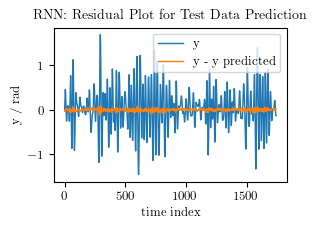

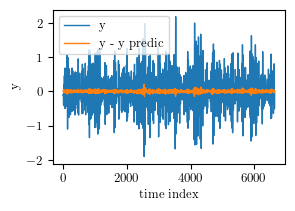

validation prediction errors:
RMS: 0.02578584093107549 radians
RMS: 1.4774198565463146 degrees
NRMS: 4.925858423260092 %


In [19]:
# predction residual plotting
histtrain, Utrain, Ytrain = convert(make_OE_init_state_data(u_train, y_train, nf=nfuture, n_encode=n_encode))
histval,   Uval,   Yval   = convert(make_OE_init_state_data(u_val,   y_val,   nf=1, n_encode=n_encode))
with torch.no_grad():
    model.eval()
    histtrain, Utrain, Ytrain = convert(make_OE_init_state_data(u_train, y_train, nf=nfuture,            n_encode=n_encode))
    histval,   Uval,   Yval   = convert(make_OE_init_state_data(u_val,   y_val,   nf=1, n_encode=n_encode))
    histTrainEval, UTrainEval, YTrainEval = convert(make_OE_init_state_data((u_data[-testStartIndex:]-u_mean)/u_std, (th_data[-testStartIndex:]-y_mean)/y_std, nf=1, n_encode=n_encode))

    Ytrain = YTrainEval * y_std + y_mean
    Ytrain_pred = model(inputs=UTrainEval,hist=histTrainEval) * y_std + y_mean
    print('test prediction errors:')
    print('RMS:', torch.mean((Ytrain_pred-Ytrain)**2).item()**0.5,'radians')
    print('RMS:', torch.mean((Ytrain_pred-Ytrain)**2).item()**0.5/(2*np.pi)*360,'degrees')
    print('NRMS:', torch.mean((Ytrain_pred-Ytrain)**2).item()**0.5/y_std*100,'%')
    res = Ytrain_pred - Ytrain #b)
    plt.figure(figsize=(3,2)) #b)
    plt.plot(Ytrain.cpu()) #b)
    plt.plot(res.cpu()) #b)
    plt.xlabel('time index'); plt.ylabel('y / rad'); plt.legend(['y','y - y predicted'])#b)
    plt.title('RNN: Residual Plot for Test Data Prediction')
    #plt.savefig("RNN_Test_Prediction_error.pdf",bbox_inches='tight')
    plt.show() #b)

    Yval = Yval * y_std + y_mean
    Yval_pred = model(inputs=Uval,hist=histval) * y_std + y_mean
    res = Yval_pred - Yval #b)
    plt.figure(figsize=(3,2)) #b)
    plt.plot(Yval.cpu()) #b)
    plt.plot(res.cpu()) #b)
    plt.xlabel('time index'); plt.ylabel('y'); plt.legend(['y','y - y predic'])#b)
    plt.show() #b)
    print('validation prediction errors:')
    print('RMS:', torch.mean((Yval_pred-Yval)**2).item()**0.5,'radians')
    print('RMS:', torch.mean((Yval_pred-Yval)**2).item()**0.5/(2*np.pi)*360,'degrees')
    print('NRMS:', torch.mean((Yval_pred-Yval)**2).item()**0.5/Yval.std().item()*100,'%')

trained simulation errors:
RMS: 0.06211299225643905 radians
RMS: 3.5588123092227217 degrees
NRMS: 12.958096446293421 %


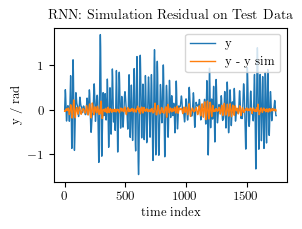

test simulation errors:
RMS: 0.025128704951059393 radians
RMS: 1.439768738325199 degrees
NRMS: 76.33447001320422 %


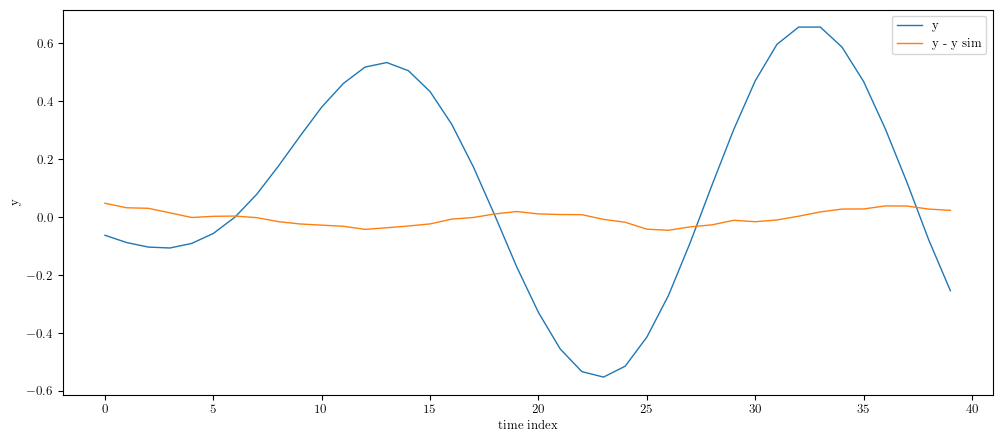

In [ ]:
# Set up simulation for identified net
# Simulation Test
out = np.load('training-val-test-data.npz')
th_train = out['th'] #th[0],th[1],th[2],th[3],...
u_train = out['u'] #u[0],u[1],u[2],u[3],...

data = np.load('hidden-test-simulation-submission-file.npz')
u_test = data['u']
th_test = data['th'] #only the first 50 values are filled the rest are zeros


def simulation_IO_model(f, ulist, ylist, skip=50):
    upast = ulist[skip-n_encode:skip].tolist() #good initialization
    ypast = ylist[skip-n_encode:skip].tolist()
    hist = np.concatenate([(upast-u_mean)/u_std,(ypast-y_mean)/y_std],axis=0)
    inputs = (np.array(ulist[skip:].tolist()) - u_mean)/u_std
    hist, inputs = convert([hist[None,:], inputs[None,:]])
    ypred = f(inputs,hist).cpu().detach().numpy() * y_std + y_mean
    Y = np.concat([ylist[:skip],ypred])
    return np.array(Y)

skip = n_encode
model.eval()
th_train_sim = simulation_IO_model(lambda x, hist: model.forward(inputs=x,hist=hist)[0], u_train[-testStartIndex:], th_train[-testStartIndex:], skip=skip)
print('trained simulation errors:')
print('RMS:', np.mean((th_train_sim[skip:]-th_train[-(testStartIndex-skip):])**2)**0.5,'radians')
print('RMS:', np.mean((th_train_sim[skip:]-th_train[-(testStartIndex-skip):])**2)**0.5/(2*np.pi)*360,'degrees')
print('NRMS:', np.mean((th_train_sim[skip:]-th_train[-(testStartIndex-skip):])**2)**0.5/th_train.std()*100,'%')
# Plotting
res = th_train_sim[skip:] - th_train[-(testStartIndex-skip):] #b)
plt.figure(figsize=(3,2)) #b)
plt.plot(th_train[-(testStartIndex-skip):]) #b)
plt.plot(res) #b)
plt.xlabel('time index'); plt.ylabel('y / rad'); plt.legend(['y','y - y sim'])#b)
#plt.xlabel('time index'); plt.ylabel('res / rad'); plt.legend(['y - y simulated'])
plt.title('RNN: Simulation Residual on Test Data')
#plt.savefig("RNN_Test_Simulation_error.pdf",bbox_inches='tight')
plt.show() #b)

skip = n_encode
th_test_sim = simulation_IO_model(lambda x,hist: model(x,hist)[0], u_test, th_test, skip=skip)
print('test simulation errors:')
print('RMS:', np.mean((th_test_sim[skip:50]-th_test[skip:50])**2)**0.5,'radians')
print('RMS:', np.mean((th_test_sim[skip:50]-th_test[skip:50])**2)**0.5/(2*np.pi)*360,'degrees')
print('NRMS:', np.mean((th_test_sim[skip:50]-th_test[skip:50])**2)**0.5/th_test.std()*100,'%')
# Plotting
res = th_test_sim[skip:50] - th_test[skip:50] #b)
plt.figure(figsize=(12,5)) #b)
plt.plot(th_test[skip:50]) #b)
plt.plot(res) #b)
plt.xlabel('time index'); plt.ylabel('y'); plt.legend(['y','y - y sim'])#b)
plt.show() #b)

In [ ]:
# import saved grid search and filter data

import pickle

file_path = 'grid_search_RNN'

with open(file_path, 'rb') as f:
    results_grid = pickle.load(f)

import pandas as pd

df = pd.DataFrame([
    {
        'n_future': params['n_future'],
        'n_hidden_encoder': params['n_hidden_encoder'],
        'n_hidden_states': params['n_hidden_states'],
        'n_hidden_h2o': params['n_hidden_h2o'],
        'n_encoder': params['n_encoder'],
        'RMS': rms
    }
    for params, rms in results_grid
    if (params['n_hidden_states'] < params['n_encoder'])
])

print(df.sort_values(by='RMS').head())


    n_future  n_hidden_encoder  n_hidden_states  n_hidden_h2o  n_encoder  \
40        40                32                8            64         10   
23        30                64                8            64         20   
28        40                16                8            16         20   
44        40                32               16            64         20   
42        40                32               16            16         20   

         RMS  
40  0.110855  
23  0.116204  
28  0.119540  
44  0.123911  
42  0.124604  


'\npivot_table = df.pivot_table(index=\'na\', columns=\'nb\', values=\'RMS\')\n\nplt.figure()\nsns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="viridis", cbar_kws={\'label\': \'RMS Error\'})\nplt.title(\'Grid Search Heatmap: na vs nb (RMS Error)\')\nplt.xlabel(\'nb\')\nplt.ylabel(\'na\')\nplt.tight_layout()\nplt.show()\n'

In [ ]:
# Submission file Generation

# Simulation
data = np.load('hidden-test-simulation-submission-file.npz')
u_test = data['u']
th_test = data['th'] #only the first 50 values are filled the rest are zeros
skip = 50
th_test_sim = simulation_IO_model(lambda x,hist: model(x,hist)[0], u_test, th_test, skip=skip)

assert len(th_test_sim)==len(th_test)
#np.savez('RNN-hidden-test-simulation-example-submission-file.npz', th=th_test_sim, u=u_test)

# Prediction
data = np.load('hidden-test-prediction-submission-file.npz')
upast_test = data['upast'] #N by u[k-15],u[k-14],...,u[k-1]
thpast_test = data['thpast'] #N by y[k-15],y[k-14],...,y[k-1]
# thpred = data['thnow'] #all zeros

upast_test = (upast_test-u_mean)/u_std
thpast_test = (thpast_test-y_mean)/y_std

U = []
Y = []
hist = []
for k in range(np.shape(upast_test)[0]-1):
    hist.append(np.concatenate((upast_test[k,-n_encode:], thpast_test[k,-n_encode:]))) #f)
    U.append(upast_test[k+1,-1]) #f)
    Y.append(thpast_test[k+1,-1]) #f)
hist.append(np.concatenate((upast_test[-1,-n_encode:], thpast_test[-1,-n_encode:])))
U.append(0)
hist, U, Y = convert([np.array(hist), np.array(U), np.array(Y)])



Ypredict = model(U[:,None],hist).detach().numpy() * y_std + y_mean
upast_test = upast_test*u_std + u_mean
thpast_test = thpast_test*y_std+y_mean
assert len(Ypredict)==len(upast_test), 'number of samples changed!!'

#np.savez('RNN-hidden-test-prediction-example-submission-file.npz', upast=upast_test, thpast=thpast_test, thnow=Ypredict)
